In this notebook, we replicate some previous network coordination detection algorithms using fast retweets. We generate networks graphs for each engagement type and then compute node centralities using eigenvalues. We then build cdf plots to determine a threshold value for coordinated activity. Finally, we do some basic qualitative analysis to better understand idealogies, opinions, etc.

In [5]:
import pandas as pd

In [6]:
import warnings
warnings.filterwarnings('ignore')

In [7]:
import numpy as np
import networkx as nx
from datetime import datetime
from datetime import timedelta

In [8]:
import scipy
import sklearn

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [9]:
from sklearn.feature_extraction.text import TfidfTransformer

In [10]:
gaza_data = pd.read_csv("~/Downloads/gaza_data/challenge_problem_two_21NOV.csv")

In [11]:
gaza_data.columns

Index(['created_at', 'follower_count', 'following_count', 'id', 'imageUrls',
       'lang', 'like_count', 'linked_tweet', 'retweet_count', 'screen_name',
       'text', 'tweet_type', 'urls'],
      dtype='object')

In [169]:
def retweet(row):
    if row['text'][0:2].lower() == 'rt':
        return 1
    else: 
        return 0

In [184]:
### let's get all retweet data & all data that is not retweets 
retweets = gaza_data[gaza_data.tweet_type == 'retweet']

In [198]:
non_retweets = gaza_data[gaza_data.tweet_type != 'retweet']

In [199]:
len(retweets)

3147621

In [200]:
len(other_tweets)

436553

In [201]:
def get_orig_author(row):
    terms = row['text'].split()
    for t in terms: 
        if t[0] == '@':
            return str(t[1:])

In [202]:
retweets['orig_author_screenname'] = retweets.apply(get_orig_author, axis=1)

In [203]:
# set the column types for linked tweet + id to be integers
retweets['id'] = retweets['id'].astype(int)
retweets['linked_tweet'] = retweets['linked_tweet'].astype(int)

In [204]:
retweets.dtypes

created_at                object
follower_count             int64
following_count            int64
id                         int64
imageUrls                 object
lang                      object
like_count                 int64
linked_tweet               int64
retweet_count              int64
screen_name               object
text                      object
tweet_type                object
urls                      object
orig_author_screenname    object
dtype: object

We start with first building the fast retweet graph:

In [205]:
from sklearn.metrics.pairwise import cosine_similarity 
#retrieves tweet's timestamp from its ID
def get_tweet_timestamp(tid):
    tid = int(tid)
    offset = 1288834974657
    tstamp = (tid >> 22) + offset
    utcdttime = datetime.utcfromtimestamp(tstamp/1000)
    return utcdttime

# Data assumptions:
#   - required user ids + tweet ids (retweet + original)
# timeInterval: time distance in seconds between retweet and original tweet under which a retweet is considered fast
def fastRetweet(dataset, timeInterval = 60):
    dataset['retweet_tweetid'] = dataset['id'].astype(int)
    dataset['retweet_userid'] = dataset['screen_name']
    dataset['tweetid'] = dataset['linked_tweet'].astype(int)
    dataset['userid'] = dataset['orig_author_screenname']
    dataset['tweet_timestamp'] = dataset['tweetid'].apply(lambda x: get_tweet_timestamp(int(x)))
    dataset['retweet_timestamp'] = dataset['retweet_tweetid'].apply(lambda x: get_tweet_timestamp(int(x)))
#     dataset = dataset[['tweetid', 'userid', 'tweet_timestamp', 
#                        'retweet_tweetid', 'retweet_userid', 'retweet_timestamp']]
    
    dataset['delta'] = (dataset['retweet_timestamp'] - dataset['tweet_timestamp']).dt.seconds
    dataset = dataset.loc[dataset['delta'] <= timeInterval]
    
    data__ = dataset.copy()
    
    dataset = dataset.groupby(['userid', 'retweet_userid'], as_index=False).count() 
    dataset = dataset.loc[dataset['delta'] > 1] #only take pairs of users that have retweeted the other more than once
    
    data_ = dataset.copy()
    
    # encode user id and retweet user id  
    enc = dict(zip(list(dataset.retweet_userid.unique()), list(range(dataset.retweet_userid.unique().shape[0]))))
    dataset['retweet_userid'] = dataset['retweet_userid'].apply(lambda x: enc[x]).astype(int)
    del enc 
    enc = dict(zip(list(dataset.userid.unique()), list(range(dataset.userid.unique().shape[0]))))
    dataset['userid'] = dataset['userid'].apply(lambda x: enc[x]).astype(int) 
    
    originals = pd.CategoricalDtype(sorted(dataset.userid.unique()), ordered=True)
    retweeters = pd.CategoricalDtype(sorted(dataset.retweet_userid.unique()), ordered=True)
    # generating sparse matrix with originals/retweeters + their deltas 
    row = dataset.userid.astype(originals).cat.codes 
    col = dataset.retweet_userid.astype(retweeters).cat.codes
    sparse_matrix = scipy.sparse.csr_matrix((dataset["delta"], (row, col)), shape=(originals.categories.size, 
                                                                             retweeters.categories.size))
    del row, col, originals, retweeters

    vectorizer = TfidfTransformer()
    tfidf_matrix = vectorizer.fit_transform(sparse_matrix)
    similarities = cosine_similarity(tfidf_matrix, dense_output=False)

    df_adj = pd.DataFrame(similarities.toarray())
    del similarities
    df_adj.index = enc.keys()
    df_adj.columns = enc.keys()
    G = nx.from_pandas_adjacency(df_adj)
    del df_adj

    G.remove_edges_from(nx.selfloop_edges(G))
    G.remove_nodes_from(list(nx.isolates(G)))

    print(G)
    return G, data_, data__


In [206]:
G, data_, data__ = fastRetweet(retweets)

Graph with 191 nodes and 302 edges


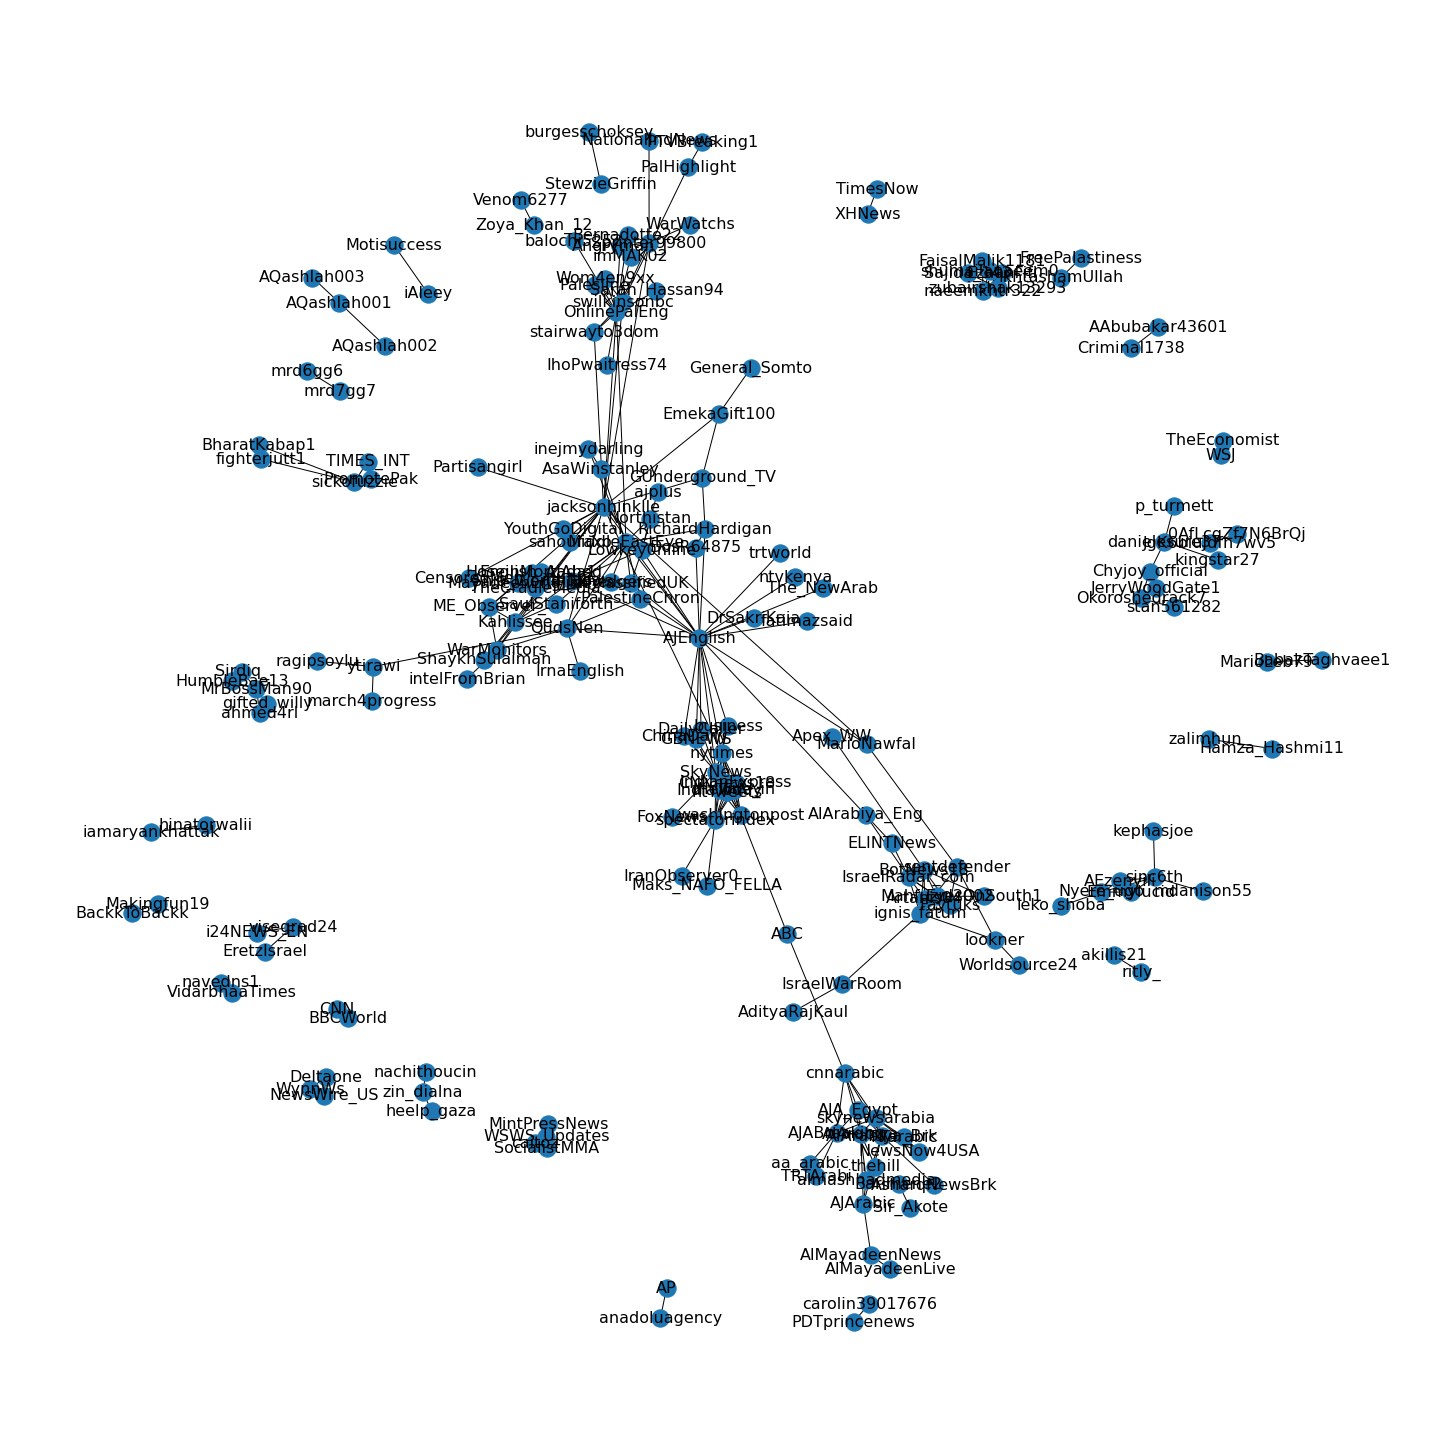

In [207]:
import matplotlib.pyplot as plt
pos = nx.spring_layout(G)
plt.figure(figsize=(20,20)) 
nx.draw(G, with_labels=True, font_size=16)

In [208]:
centrality = nx.eigenvector_centrality(G)
# centrality = sorted((v, f"{c:0.2f}") for v, c in centrality.items())

In [209]:
centrality

{'0AfLcgZf7N6BrQj': 2.3636680365390412e-30,
 'AAbubakar43601': 2.3636680365390412e-30,
 'ABC': 0.03606446061323726,
 'AEzenyili': 2.9788570350739646e-16,
 'AJABreaking': 0.0012660024005295102,
 'AJA_Egypt': 0.0012298051669365037,
 'AJArabic': 0.0003730174923929753,
 'AJEnglish': 0.21346783908897185,
 'AP': 2.3636680365390412e-30,
 'AQashlah001': 9.341074331835612e-27,
 'AQashlah002': 6.60513700360856e-27,
 'AQashlah003': 6.60513700360856e-27,
 'AdityaRajKaul': 2.839197350625169e-05,
 'AlArabiya': 0.0013251656751375469,
 'AlArabiya_Brk': 0.0014036673364309106,
 'AlArabiya_Eng': 0.02631155866183744,
 'AlMayadeenLive': 5.33297350579182e-06,
 'AlMayadeenNews': 4.4918507475922015e-05,
 'Angryman_J': 0.00916548431545726,
 'Apex_WW': 0.00016201619162366335,
 'Artanis04': 0.0013129932595218438,
 'AsaWinstanley': 0.010802352871024974,
 'AsharqNewsBrk': 0.00016664263358172435,
 'BBCWorld': 2.3636680365390412e-30,
 'BabakTaghvaee1': 2.3636680365390412e-30,
 'BackkToBackk': 2.3636680365390412e-30,

In [210]:
values = [v for k, v in centrality.items()]

In [211]:
idxs = np.argsort(values)
users = [k for k, v in centrality.items()]

In [212]:
values.sort()
values.reverse()
values[:5]

[0.36220153146952777,
 0.3410144072281986,
 0.3025245533586822,
 0.2987292427934591,
 0.29490214355841177]

In [213]:
sorted_users = [users[i] for i in idxs]
sorted_users.reverse()
sorted_users[:5]

['SkyNews', 'nytimes', 'spectatorindex', 'washingtonpost', 'IndianExpress']

In [214]:
len(values)

191

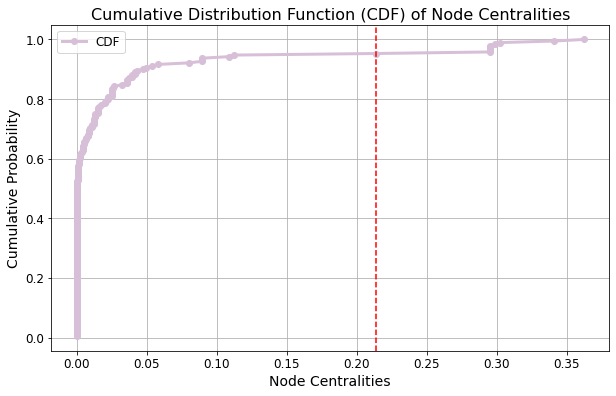

In [260]:
import matplotlib.pyplot as plt
import numpy as np

# Your node centralities
centralities = values # Include the full list

# Sort the centralities
sorted_centralities = np.sort(centralities)

# Calculate the cumulative distribution function (CDF)
cdf = np.arange(1, len(sorted_centralities) + 1) / len(sorted_centralities)

# Create a larger and nicer figure
plt.figure(figsize=(10, 6))

# Create the CDF plot with a thicker line in a lighter purple color
plt.plot(sorted_centralities, cdf, label='CDF', linewidth=3, marker='o', color='#d8bfd8', linestyle='-')

# Add labels and title with increased font size
plt.xlabel('Node Centralities', fontsize=14)
plt.ylabel('Cumulative Probability', fontsize=14)
plt.title('Cumulative Distribution Function (CDF) of Node Centralities', fontsize=16)

# Set grid, legend, and adjust tick font size
plt.grid(True)
plt.legend(fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Add a vertical line when CDF reaches 0.7
threshold_cdf = 0.95
threshold_index = np.argmax(cdf >= threshold_cdf)
threshold_centrality = sorted_centralities[threshold_index]
plt.axvline(threshold_centrality, color='red', linestyle='--', label=f'CDF = {threshold_cdf}')


# Show the plot
plt.show()


In [275]:
def nodes_above_cdf_threshold(centralities, node_names, cdf_threshold):
    """
    Returns a list of node names whose cumulative density values are above the given threshold.

    Parameters:
    - centralities (list): List of node centralities.
    - node_names (list): List of corresponding node names.
    - cdf_threshold (float): Cumulative density threshold value.

    Returns:
    - list: Nodes with cumulative density values above the threshold.
    """
    sorted_indices = np.argsort(centralities)
    sorted_cdf = np.cumsum(np.ones_like(centralities)) / len(centralities)
#     print(sorted_cdf)
    above_threshold_nodes = [node_names[i] for i in sorted_indices if sorted_cdf[i] > cdf_threshold]
    return above_threshold_nodes

# Example usage:
centralities = values
node_names = sorted_users
cdf_threshold_value = 0.95

above_cdf_threshold_nodes = nodes_above_cdf_threshold(centralities, node_names, cdf_threshold_value)
print(f"Nodes with cumulative density values above {cdf_threshold_value}: {above_cdf_threshold_nodes}")


Nodes with cumulative density values above 0.95: ['0AfLcgZf7N6BrQj', 'BabakTaghvaee1', 'BackkToBackk', 'Barimene2', 'Venom6277', 'iamaryankhattak', 'CNN', 'iAleey', 'akillis21', 'IkhtashamUllah']


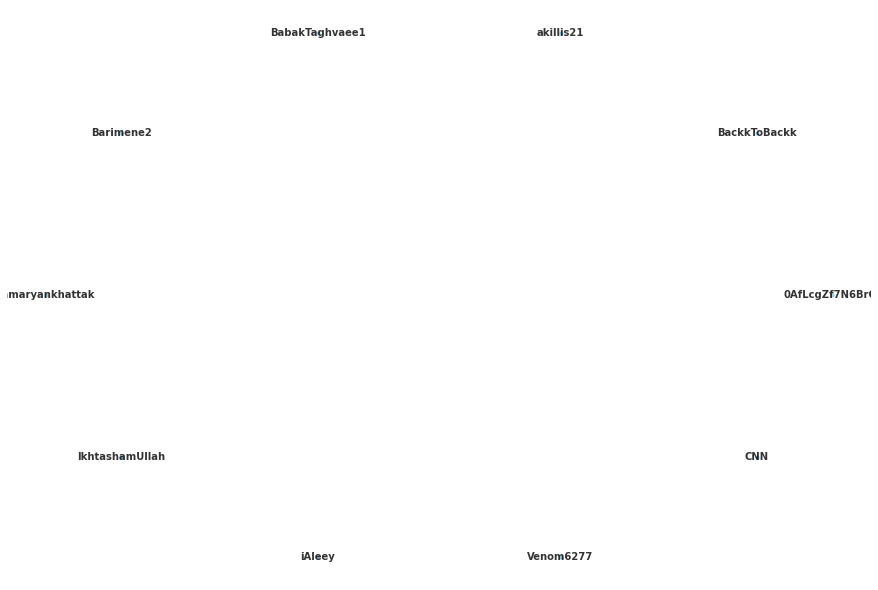

In [276]:
# print(len(above_cdf_threshold_nodes))
subgraph = G.subgraph(above_cdf_threshold_nodes)

# Create a new graph with the subgraph
new_G = nx.Graph(subgraph)

import matplotlib.pyplot as plt
# Define a layout for the graph (e.g., circular layout)
# layout = nx.circular_layout(new_G)

plt.figure(figsize=(12,8)) 


# Draw the graph with labels
nx.draw(new_G, pos=layout, with_labels=True, arrows=True, width=1.5, font_weight='bold', node_size=10, font_size=10, node_color='skyblue', edge_color='gray', linewidths=1, alpha=0.8)


In [274]:
above_cdf_threshold_nodes

['0AfLcgZf7N6BrQj']

In [285]:
#   'BackkToBackk', 'Venom6277', 
# 'iamaryankhattak', ' , 'IkhtashamUllah'
other_users = [ 
#     'StewzieGriffin',
                    
#                     'Motisuccess',
#                     'MarioLeb79',
#                     'navedns1',
                    'Venom6277',
#                     'carolin39017676',
#                     'Criminal1738',
#                     'Zoya_Khan_12',
#  'mrd6gg6'
]

In [286]:
news_outlets = [
#     'BBCWorld',
#     'AP',
#     'anadoluagency',
#     'TheEconomist',
#     'TimesNow',
    'BabakTaghvaee1',
#     'VidarbhaaTimes',
    'CNN',
#     'WSJ',
#     'XHNews',
#     'i24NEWS_EN'
]

In [287]:
suspended = [
    '0AfLcgZf7N6BrQj',
#     'Makingfun19',
#     'JgK6biuJdfn7wv5',
#     'mrd7gg7',
#     'burgesschoksey',
    'BackkToBackk',
    'akillis21'
]

In [288]:
deleted = [
#     'FreePalastiness',
#     'PDTprincenews',
    'Barimene2',
    'iamaryankhattak',
    'IkhtashamUllah',
#     'hinatorwalii'
]

In [289]:
# > 5k followers
pop_figures = [
#     'Hamza_Hashmi11',
    'iAleey',
#     'Sir_Akote',
#     'zalimhun_' ,
#     'AAbubakar43601',
#     'ritly_'
]

['BabakTaghvaee1', 'CNN']


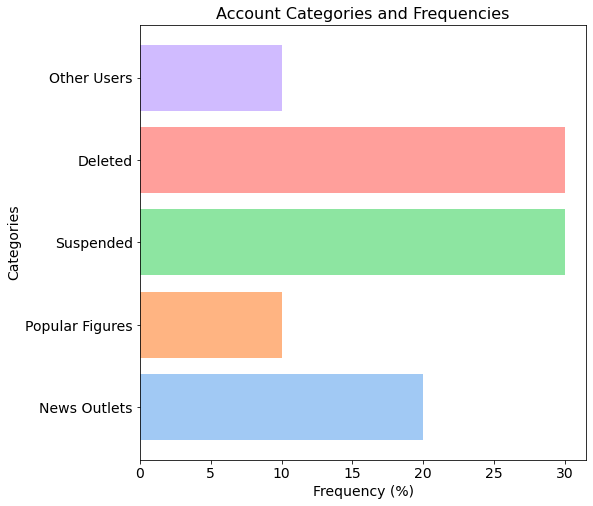

In [290]:
import matplotlib.pyplot as plt
import seaborn as sns

# Combine all lists into one
all_accounts = news_outlets + other_users + suspended + deleted + pop_figures
print(news_outlets)

# Calculate frequencies
total_accounts = len(all_accounts)
news_outlets_freq = len(news_outlets) / total_accounts * 100
pop_figures_freq = len(pop_figures) / total_accounts * 100
suspended_freq = len(suspended) / total_accounts * 100
deleted_freq = len(deleted) / total_accounts * 100
other_users_freq = len(other_users) / total_accounts * 100

# Use a Seaborn pastel color palette
pastel_colors = sns.color_palette("pastel", n_colors=6)

# Create a horizontal bar graph with different pastel colors
categories = ['News Outlets', 'Popular Figures', 'Suspended', 'Deleted', 'Other Users']
frequencies = [news_outlets_freq, pop_figures_freq, suspended_freq, deleted_freq, other_users_freq]
plt.figure(figsize=(8,8)) 

plt.barh(categories, frequencies, color=pastel_colors)
plt.xlabel('Frequency (%)', fontsize=14)
plt.ylabel('Categories', fontsize=14)
plt.title('Account Categories and Frequencies', fontsize=16)

# Increase tick label font size
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

# Show the plot
plt.show()


In [291]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch

tokenizer = AutoTokenizer.from_pretrained("bert-base-cased")
model = AutoModelForSequenceClassification.from_pretrained("bucketresearch/politicalBiasBERT")

In [292]:
gaza_data.columns

Index(['created_at', 'follower_count', 'following_count', 'id', 'imageUrls',
       'lang', 'like_count', 'linked_tweet', 'retweet_count', 'screen_name',
       'text', 'tweet_type', 'urls'],
      dtype='object')

In [306]:
d = {0: 'left', 1: 'center', 2: 'right'}
all_accounts = news_outlets + other_users + suspended + deleted + pop_figures
print(all_accounts)
lefts = []
rights = []
centers = []
for account in all_accounts: 
    left = []
    right = []
    center = []
    texts = retweets[retweets['screen_name'] == account].text.values
    if len(texts) == 0:
        texts = retweets[retweets['orig_author_screenname'] == account].text.values
    print("texts: ", len(texts))
    for t in texts: 
        inputs = tokenizer(t, return_tensors="pt")
        labels = torch.tensor([0])
        outputs = model(**inputs, labels=labels)
        loss, logits = outputs[:2]
        l, c, r = logits.softmax(dim=-1)[0].tolist()
        left.append(l)
        center.append(c)
        right.append(r)
    print("Account: ", account)
    print("Polarities: ", end='\t')
    lefts.append(sum(left)/len(left))
    print("Left: ", sum(left)/len(left), end=' ')
    centers.append(sum(center)/len(center))
    print("Center: ", sum(center)/len(center), end=' ')
    rights.append(sum(right)/len(right))
    print("Right: ", sum(right)/len(right), end='\n')

['BabakTaghvaee1', 'CNN', 'Venom6277', '0AfLcgZf7N6BrQj', 'BackkToBackk', 'akillis21', 'Barimene2', 'iamaryankhattak', 'IkhtashamUllah', 'iAleey']
texts:  354
Account:  BabakTaghvaee1
Polarities: 	Left:  0.06048379181016047 Center:  0.8216393885891989 Right:  0.11787682013601948
texts:  1453
Account:  CNN
Polarities: 	Left:  0.9837835483914479 Center:  0.011885164421101735 Right:  0.004331286069046108
texts:  100
Account:  Venom6277
Polarities: 	Left:  0.024162991819903255 Center:  0.94948785841465 Right:  0.026349148366134615
texts:  1
Account:  0AfLcgZf7N6BrQj
Polarities: 	Left:  0.07850683480501175 Center:  0.28239133954048157 Right:  0.6391018033027649
texts:  6
Account:  BackkToBackk
Polarities: 	Left:  0.26541174824039143 Center:  0.5348893279830614 Right:  0.19969894364476204
texts:  701
Account:  akillis21
Polarities: 	Left:  0.08947327200020432 Center:  0.8211309016654308 Right:  0.08939584971441437
texts:  1
Account:  Barimene2
Polarities: 	Left:  0.512394905090332 Center:  0

In [305]:
len(['BabakTaghvaee1', 'CNN', 'Venom6277', '0AfLcgZf7N6BrQj', 'BackkToBackk', 'akillis21', 'Barimene2', 'iamaryankhattak', 'IkhtashamUllah', 'iAleey'])

10

10


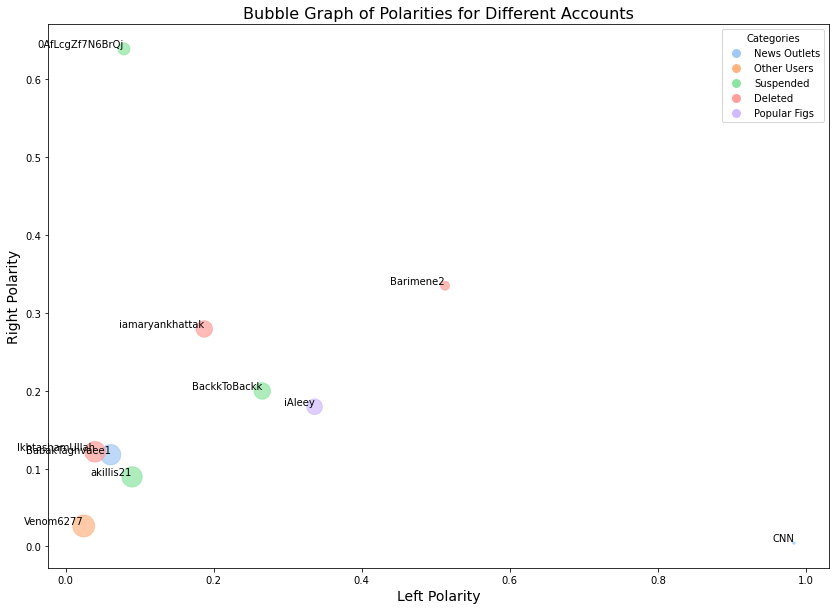

In [313]:
#most polarized: JgK6biuJdfn7wv5, Right, 0.6689691543579102
#CNN, Left, 0.9837835483914479

import matplotlib.pyplot as plt
import seaborn as sns

# Extracting data for plotting
left_polarity = lefts
right_polarity = rights
center_polarity = centers

# Use a Seaborn pastel color palette
pastel_colors = sns.color_palette("pastel", n_colors=len(accounts))

# Assign colors based on account categories
colors = []
for account in all_accounts:
    if account in news_outlets:
        colors.append(pastel_colors[0])
    elif account in other_users:
        colors.append(pastel_colors[1])
    elif account in suspended:
        colors.append(pastel_colors[2])
    elif account in deleted:
        colors.append(pastel_colors[3])
    elif account in pop_figures:
        colors.append(pastel_colors[4])
        
print(len(left_polarity))

# Create a scatter plot (bubble graph)
plt.figure(figsize=(14, 10))
plt.scatter(lefts, rights, s=[500 * size for size in center_polarity], c=colors, alpha=0.7)

# Annotate points with account names
for i, txt in enumerate(all_accounts):
    plt.annotate(txt, (lefts[i], rights[i]), fontsize=10, ha='right', va='bottom')

# Set axis labels and title
plt.xlabel('Left Polarity', fontsize=14)
plt.ylabel('Right Polarity', fontsize=14)
plt.title('Bubble Graph of Polarities for Different Accounts', fontsize=16)

# Create a custom legend
legend_labels = ['News Outlets', 'Other Users', 'Suspended', 'Deleted', 'Popular Figs']
legend_handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=10) for color in pastel_colors]
legend = plt.legend(handles=legend_handles, labels=legend_labels, title='Categories', loc='upper right', bbox_to_anchor=(1, 1))

# Show the plot
plt.show()


In [ ]:
# Dictionary to store highest polarities for each user
highest_polarities = {}

# Iterate through the data to find the highest 'Center' polarity for each user
# Dictionary to store highest polarities for each user
highest_polarities = {}

# Iterate through the data to find the highest polarity for each user
for entry in data:
    account = entry['Account']
    left_polarity = entry['Left']
    center_polarity = entry['Center']
    right_polarity = entry['Right']

    if account not in highest_polarities:
        highest_polarities[account] = {'Label': '', 'Value': 0}

    # Find the label and value with the highest polarity
    highest_label = max(['Left', 'Center', 'Right'], key=lambda label: entry[label])
    highest_value = entry[highest_label]

    # Update the dictionary if the current polarity is higher
    if highest_value > highest_polarities[account]['Value']:
        highest_polarities[account] = {'Label': highest_label, 'Value': highest_value}

# Print the result
for account, values in highest_polarities.items():
    print(f"{account}, {values['Label']}, {values['Value']}")

In [116]:
# users who retweeted each other the most
data_.sort_values(by=['delta'], ascending=False)

,userid,retweet_userid,created_at,follower_count,following_count,id,imageUrls,lang,like_count,linked_tweet,...,screen_name,text,tweet_type,urls,orig_author_screenname,retweet_tweetid,tweetid,tweet_timestamp,retweet_timestamp,delta
4327,Cheerybutter,Cheerybutter,128,128,128,128,128,128,128,128,...,128,128,128,128,128,128,128,128,128,128
3820,BotNews18,Ariful08674940,53,53,53,53,53,53,53,53,...,53,53,53,53,53,53,53,53,53,53
21942,engelabiha,haj__majid,40,40,40,40,40,40,40,40,...,40,40,40,40,40,40,40,40,40,40
21940,engelabiha,engelabi313,38,38,38,38,38,38,38,38,...,38,38,38,38,38,38,38,38,38,38
21944,engelabiha,mehdi_bakery,35,35,35,35,35,35,35,35,...,35,35,35,35,35,35,35,35,35,35
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13912,QudsNen,Israel1Canada,2,2,2,2,2,2,2,2,...,2,2,2,2,2,2,2,2,2,2
13899,QudsNen,HDasht1,2,2,2,2,2,2,2,2,...,2,2,2,2,2,2,2,2,2,2
13888,QudsNen,Faujijpn_,2,2,2,2,2,2,2,2,...,2,2,2,2,2,2,2,2,2,2
13884,QudsNen,FaruMuru,2,2,2,2,2,2,2,2,...,2,2,2,2,2,2,2,2,2,2


In [197]:
data__[data__.tweet_type=='retweet'].sort_values(['delta'])[:50]#.text.values

,created_at,follower_count,following_count,id,imageUrls,lang,like_count,linked_tweet,retweet_count,screen_name,...,tweet_type,urls,orig_author_screenname,retweet_tweetid,retweet_userid,tweetid,userid,tweet_timestamp,retweet_timestamp,delta
8699,2023-09-19 19:12:41,579,334,1704211930116678082,['http://pbs.twimg.com/media/F6VKHxmXgAA1bbK.j...,Arabic,0,1703849539700973824,0,zainalyaseri,...,retweet,[],US_World1,1704211930116678082,zainalyaseri,1703849539700973824,US_World1,2023-09-18 19:12:40.915,2023-09-19 19:12:41.523,0
2018361,2023-10-23 09:34:50,502,465,1716387695986147352,[],English,0,1716025307080045056,0,jurryindaeyo,...,retweet,[],DrLoupis,1716387695986147352,jurryindaeyo,1716025307080045056,DrLoupis,2023-10-22 09:34:50.073,2023-10-23 09:34:50.321,0
572668,2023-10-11 02:05:57,1994,2644,1711926077998948543,[],English,0,1711201301575438848,0,SteveFGriffin,...,retweet,[],CraigMurrayOrg,1711926077998948543,SteveFGriffin,1711201301575438848,CraigMurrayOrg,2023-10-09 02:05:57.535,2023-10-11 02:05:57.700,0
406684,2023-10-09 18:43:20,29506,10202,1711452300605084153,['http://pbs.twimg.com/media/F78DMmMWMAAkSLj.j...,English,0,1711089910206144512,0,A_Y_Rafindadi,...,retweet,[],A_Y_Rafindadi,1711452300605084153,A_Y_Rafindadi,1711089910206144512,A_Y_Rafindadi,2023-10-08 18:43:19.763,2023-10-09 18:43:20.367,0
2042233,2023-10-23 14:12:24,337,865,1716457546599559276,[],English,0,1716095157731278848,0,voter55yrs,...,retweet,['https://www.cnn.com/middleeast/live-news/isr...,cnnbrk,1716457546599559276,voter55yrs,1716095157731278848,cnnbrk,2023-10-22 14:12:23.766,2023-10-23 14:12:24.005,0
3160952,2023-10-09 12:07:50,35,177,1711352771121709300,[],English,0,1710990380336885760,0,JV2022CA,...,retweet,[],RepMTG,1711352771121709300,JV2022CA,1710990380336885760,RepMTG,2023-10-08 12:07:49.993,2023-10-09 12:07:50.689,0
3030304,2023-11-01 17:38:22,95,419,1719770871777378589,[],English,0,1719408481378131968,0,gaitatito,...,retweet,[],inejmydarling,1719770871777378589,gaitatito,1719408481378131968,inejmydarling,2023-10-31 17:38:21.682,2023-11-01 17:38:22.286,0
3162988,2023-10-09 13:13:43,89,269,1711369349372481940,['https://video.twimg.com/amplify_video/171086...,English,0,1711006958294077440,0,rrausch76,...,retweet,[],GrahamAllen_1,1711369349372481940,rrausch76,1711006958294077440,GrahamAllen_1,2023-10-08 13:13:42.486,2023-10-09 13:13:43.252,0
1544797,2023-10-18 19:45:43,50,34,1714729490780152149,['https://video.twimg.com/amplify_video/171436...,English,0,1714367101450785024,0,AraruRaliya,...,retweet,[],Lowkey0nline,1714729490780152149,AraruRaliya,1714367101450785024,Lowkey0nline,2023-10-17 19:45:43.043,2023-10-18 19:45:43.392,0
2142579,2023-10-24 18:53:37,4087,1038,1716890708215538038,[],English,0,1716528317593977344,0,cherylbenson,...,retweet,['https://www.thestar.com/opinion/contributors...,DesmondCole,1716890708215538038,cherylbenson,1716528317593977344,DesmondCole,2023-10-23 18:53:37.125,2023-10-24 18:53:37.782,0


In [145]:
data__[data__.id == 1719818555959505039].text.values

array(['2/2 I am here watching @piersmorgan interview with @Byoussef. Bassem raised a similar question in the first interview. What’s the logic of Israel bombing Gaza? What do they hope to achieve with continued bombing?'],
      dtype=object)

In [130]:
retweets[retweets.text == 'servant, you can have a kingdom without freedom, democracy, human rights, freedom of speech and... BREAKING: Jordanian security forces fire teargas at thousands of Jordanian protesters marching to the border with occupied Palestine in protest of the Israeli aggression on Gaza.']

,created_at,follower_count,following_count,id,imageUrls,lang,like_count,linked_tweet,retweet_count,screen_name,...,tweet_type,urls,orig_author_screenname,retweet_tweetid,retweet_userid,tweetid,userid,tweet_timestamp,retweet_timestamp,delta
793527,2023-10-13 09:54:56,616,1466,1712768877157900758,[],English,0,1712768871038423296,0,bdlmhdy22671055,...,reply,[],None,1712768877157900758,bdlmhdy22671055,1712768871038423296,None,2023-10-13 09:54:55.219,2023-10-13 09:54:56.678,1


In [125]:
text = "والسؤال التاني: إيه الجديد أو النجاح اللي هتنجزه إسرائيل من هجومها على غزة بداعي الدفاع عن نفسها ومحاربة الإرهاب طالما كل الأفعال المشابهة اللي عملتها خلال أكتر من 50 سنة لم تجني إلا الآلاف من الضحايا المدنيين فقط؟!!! #piersmorgan #talktv #debate"
tokenizer = AutoTokenizer.from_pretrained("bert-base-cased")

model = AutoModelForSequenceClassification.from_pretrained("bucketresearch/politicalBiasBERT")


inputs = tokenizer(text, return_tensors="pt")
labels = torch.tensor([0])
outputs = model(**inputs, labels=labels)
loss, logits = outputs[:2]

print(logits.softmax(dim=-1)[0].tolist()) 

[0.17212678492069244, 0.21957701444625854, 0.6082961559295654]


In [126]:
retweets[retweets.text == text]

,created_at,follower_count,following_count,id,imageUrls,lang,like_count,linked_tweet,retweet_count,screen_name,...,tweet_type,urls,orig_author_screenname,retweet_tweetid,retweet_userid,tweetid,userid,tweet_timestamp,retweet_timestamp,delta
1443490,2023-10-18 05:25:57,168,76,1714513121786667011,[],Arabic,0,1714513119878197504,0,alsadek27,...,reply,[],None,1714513121786667011,alsadek27,1714513119878197504,None,2023-10-18 05:25:56.549,2023-10-18 05:25:57.004,0


In [335]:
data__[data__['orig_author_screenname'] == '0AfLcgZf7N6BrQj'].sort_values(['delta']).screen_name.values[0]

'MqE1geqaa'